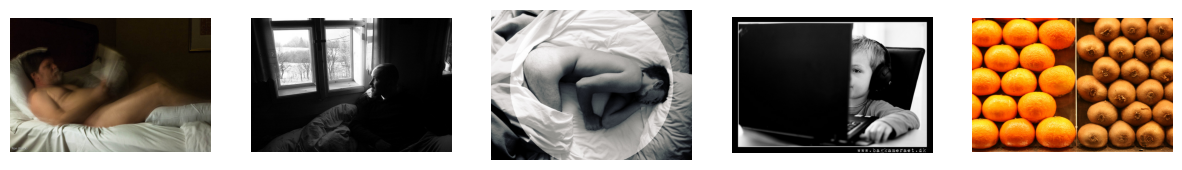

In [4]:
import re, string
from gensim.models import KeyedVectors
import math
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtyping import TensorType
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import pickle
import numpy as np
import mynn

import mygrad as mg

# MyNN imports
from mynn.layers.dense import dense
from mygrad.nnet.activations import relu
from mygrad.nnet.initializers import he_normal
from mynn.losses.mean_squared_loss import mean_squared_loss
from mygrad.nnet.losses import softmax_crossentropy
from mynn.optimizers.sgd import SGD
from mynn.optimizers.adam import Adam
# what ^^???

#hlloeoeifhie
# wow!!! hello world :)

# Loading COCO Data
from cogworks_data.language import get_data_path

from pathlib import Path
import json

# load COCO metadata
filename = get_data_path("captions_train2014.json")
with Path(filename).open() as f:
    coco_data = json.load(f)

# load saved image descriptor vectors
with Path(get_data_path('resnet18_features.pkl')).open('rb') as f:
    #resnet 18 is a dict that stores a d_image for each image
    # image-ID -> shape (512,) descriptor
    resnet18_features = pickle.load(f)

# Changed from the previous implementation
# filter out the COCO images that don't have ResNet descriptors associated with them
filtered_images = [img for img in coco_data["images"] if img["id"] in resnet18_features]
coco_data["images"] = filtered_images


# Organizing the COCO data: - Heidi 

# 	•	Create a class that organizes all of the COCO data. It might store the following:
# 	•	All the image IDs
# 	•	All the caption IDs
# 	•	Various mappings between image/caption IDs, and associating caption-IDs with captions
# 	•	image-ID -> [cap-ID-1, cap-ID-2, …]
# 	•	caption-ID -> image-ID
# 	•	caption-ID -> caption (e.g. 24 -> “two dogs on the grass”)

class Coco:
    def __init__(self, data):
        self.images = data["images"]
        self.annotations = data["annotations"]

        self.image_id_to_caption_ids = {}
        self.caption_id_to_image_id = {}
        self.caption_id_to_caption = {}
        self.image_id_to_file_name = {}

        for annotation in self.annotations:
            image_id = annotation["image_id"]
            caption_id = annotation["id"]
            caption = annotation["caption"]
            
            if image_id not in self.image_id_to_caption_ids:
                self.image_id_to_caption_ids[image_id] = []
            # Changed from the previous implementation
            self.image_id_to_caption_ids[image_id].append(caption_id)
            self.caption_id_to_image_id[caption_id] = image_id
            self.caption_id_to_caption[caption_id] = caption
        
        for image in self.images:
            image_id = image["id"]
            file_name = image["file_name"]
            self.image_id_to_file_name[image_id] = file_name
            
    
    def getCaptionIDs(self, image_id):
        return self.image_id_to_caption_ids[image_id]
    
    def getImageID(self, caption_id):
        return self.caption_id_to_image_id[caption_id]
    
    def getCaption(self, caption_id):
        return self.caption_id_to_caption[caption_id]
    
    def getImageFileName(self, image_id):
        return self.image_id_to_file_name[image_id]


def calc_image_embedding(image_id, W_embed):
    image_dizkriptor = resnet18_features[image_id]
    #print(image_dizkriptor.shape)
    image_embedding = np.matmul(image_dizkriptor, W_embed)
    image_embedding = image_embedding.reshape(200,)
    return image_embedding

import io
import requests
from PIL import Image
import matplotlib.pyplot as plt
def download_image(img_url: str) -> Image:
    response = requests.get(img_url)
    return Image.open(io.BytesIO(response.content))

# Inherent from Coco, add more functions
class MyDatabase(Coco):
    # data should come from validation set!
    def __init__(self, data, W_embed):
        super().__init__(data)

        # Calculate the embeddings for all images, and store them
        self.image_id_to_embedding = {}
        self.image_id_to_url = {}

        for image in self.images:
            image_id = image["id"]
            image_embedding = calc_image_embedding(image_id, W_embed)
            self.image_id_to_embedding[image_id] = image_embedding
            self.image_id_to_url[image_id] = image["coco_url"]

    def getImageEmbedding(self, image_id):
        return self.image_id_to_embedding[image_id]
    
    def getImageUrl(self, image_id):
        return self.image_id_to_url[image_id]
    
    def queryByCaptionEmbedding(self, caption_embedding, top_k=5):
        similarities = []
        
        for image_id, image_embedding in self.image_id_to_embedding.items():
            # Calculate cosine similarity
            sim = np.dot(caption_embedding, image_embedding) / (np.linalg.norm(caption_embedding) * np.linalg.norm(image_embedding))
            similarities.append((image_id, sim))
        
        # Sort based on similarity scores in descending order and get top-k
        similarities.sort(key=lambda x: x[1], reverse=True)
        top_k_images = similarities[:top_k]
        
        return top_k_images
    
    # display k images given their ids.
    def displayImages(self, image_ids):
        images = []
        for image_id in image_ids:
            img_url = self.getImageUrl(image_id)
            img = download_image(img_url)
            images.append(img)

        # Display images using matplotlib
        fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
        if len(images) == 1:
            axes = [axes]
        
        for ax, img in zip(axes, images):
            ax.imshow(img)
            ax.axis('off')
        plt.show()


# Example usage
db = MyDatabase(coco_data, np.random.rand(512, 200))
db.getImageEmbedding(57870)
top_k = db.queryByCaptionEmbedding(np.random.rand(200))
top_k_IDs = [pair[0] for pair in top_k]
db.displayImages(top_k_IDs)